<a href="https://colab.research.google.com/github/shazzad-hasan/few-shot-learning/blob/main/OSL/OSL_siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available")
else:
  print("CUDA is available")

device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is available


In [3]:
train_data = datasets.Omniglot(root="./data", download=True, transform=None)
test_data = datasets.Omniglot(root="./data", background = False, download=True, transform=None)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


In [4]:
root_dir = '/content/data/omniglot-py/images_evaluation/'
categories = [[folder, os.listdir(root_dir + folder)] for folder in os.listdir(root_dir)  if not folder.startswith('.') ]

In [30]:
class OmniglotDataset(Dataset):
  def __init__(self, categories, root_dir, data_size, transform=None):
    self.catagories = categories
    self.root_dir = root_dir 
    self.transform = transform
    self.data_size = data_size 

  def __len__(self):
    return self.data_size 

  def __getitem__(self, idx):
    img1, img2, label = None, None, None

    if idx%2==0:
      category = random.choice(categories)
      character = random.choice(category[1])
      img_dir = root_dir + category[0] + "/" + character
      img1_name = random.choice(os.listdir(img_dir))
      img2_name = random.choice(os.listdir(img_dir))
      img1 = Image.open(img_dir + "/" + img1_name)
      img2 = Image.open(img_dir + "/" + img2_name)
      label = 1.0

    else:
      category1 = random.choice(categories)
      category2 = random.choice(categories)
      character1 = random.choice(category1[1])
      character2 = random.choice(category2[1])
      img_dir1 = root_dir + category1[0] + "/" + character1
      img_dir2 = root_dir + category2[0] + "/" + character2 
      img1_name = random.choice(os.listdir(img_dir1))
      img2_name = random.choice(os.listdir(img_dir2))

      while img1_name == img2_name:
        img2_name = random.choice(os.listdir(img_dir2))
      label = 0.0
      img1 = Image.open(img_dir1 + "/" + img1_name)
      img2 = Image.open(img_dir2 + "/" + img2_name)

    if self.transform:
      img1 = self.transform(img1)
      img2 = self.transform(img2)
    label = np.array([label], dtype=np.float32)

    return img1, img2, label

In [31]:
data_size = 10000
# choose percentage of training data for validation
valid_pct = 0.2
train_size = int(valid_pct * data_size)
valid_size = data_size - train_size

transform = transforms.Compose(
    [transforms.ToTensor()])

omniglot_data = OmniglotDataset(categories, root_dir, data_size, transform)
train_data, valid_data = random_split(omniglot_data, [train_size, valid_size])

## define dataloader parameters
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)

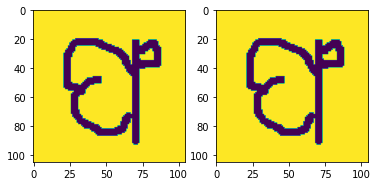

In [34]:
for img1, img2, label in train_loader:
  if label[0] == 1.0:
    plt.subplot(1,2,1)
    plt.imshow(img1[0][0])
    plt.subplot(1,2,2)
    plt.imshow(img2[0][0])
    break

In [27]:
class nWayOneShotValidSet(Dataset):
  def __init__(self, categories, root_dir, data_size, n_way, transform=None):
    self.categories = categories
    self.root_dir = root_dir
    self.data_size = data_size 
    self.n_way = n_way 
    self.transform = transform 
  
  def __len__(self):
    return self.data_size 

  def __getitem__(self, idx):
    category = random.choice(categories)
    character = random.choice(category[1])
    img_dir = root_dir + category[0] + "/" + character
    img_name = random.choice(os.listdir(img_dir)) 
    main_img = Image.open(img_dir + "/" + img_name)
    if self.transform:
      main_img = self.transform(main_img)

    test_set = []
    label = np.random.randint(self.nWay)
    for i in range(self.n_way):
      test_img_dir = img_dir 
      test_img_name = ""
      # find a random image from the from the same set as the main
      if i == label:
        test_img_name = random.choice(os.listdir(img_dir))
      else:
        test_category = random.choice(categories)
        test_character = random.choice(test_category[1])
        test_img_dir = root_dir + test_category[0] + "/" + test_character 
        while test_img_dir == img_dir:
          test_img_dir = root_dir + test_category[0] + "/" + test_character 
      test_img_name = random.choice(os.listdir(test_img_dir))
      if self.transform:
        test_img = self.transform(test_img)
      test_set.append(test_img)

    label = torch.from_numpy(np.array([label], dtype=int))
    return main_img, test_set, label

In [29]:
test_size = 5000
n_way = 20
batch_size = 1
num_workers = 0

test_data = nWayOneShotValidSet(categories, root_dir, test_size, n_way, transform)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)